<a href="https://colab.research.google.com/github/julia-lina-tan/TSP/blob/master/bhmFusion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!git clone https://github.com/julia-lina-tan/TSP.git

Cloning into 'TSP'...
remote: Enumerating objects: 81, done.
remote: Counting objects: 100% (81/81), done.
remote: Compressing objects: 100% (74/74), done.
remote: Total 81 (delta 18), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (81/81), done.


In [3]:
%cd BHM

rm: cannot remove 'TSP': No such file or directory
/content/BHM


#Bayesian Hilbert Maps

In [4]:
"""
# 2D and 3D Bayesian Hilbert Maps with pytorch
# Ransalu Senanayake
"""
import torch as pt
import numpy as np
from sklearn.metrics.pairwise import rbf_kernel
import matplotlib.pyplot as pl
from mpl_toolkits.mplot3d import Axes3D
import time
import sys
import pandas as pd

dtype = pt.float32
device = pt.device("cpu")
# device = pt.device("cuda:0") # Uncomment this to run on GPU

class BHM2D_PYTORCH():
    def __init__(self, gamma=0.05, grid=None, cell_resolution=(5, 5), cell_max_min=None, X=None, nIter=0, mu_sig=None):
        """
        :param gamma: RBF bandwidth
        :param grid: if there are prespecified locations to hinge the RBF
        :param cell_resolution: if 'grid' is 'None', resolution to hinge RBFs
        :param cell_max_min: if 'grid' is 'None', realm of the RBF field
        :param X: a sample of lidar locations to use when both 'grid' and 'cell_max_min' are 'None'
        """
        self.gamma = gamma
        if grid is not None:
            self.grid = grid
        else:
            self.grid = self.__calc_grid_auto(cell_resolution, cell_max_min, X)
        self.nIter = nIter
        print(' Number of hinge points={}'.format(self.grid.shape[0]))

        #ADDED
        if mu_sig is not None:
            self.mu = pt.tensor(mu_sig[:,0], dtype=pt.float32)
            self.sig = pt.tensor(mu_sig[:,1], dtype=pt.float32)

    def updateGrid(grid):
        self.grid = grid

    def updateMuSig(mu_sig):
        self.mu = pt.tensor(mu_sig[:,0], dtype=pt.float32)
        self.sig = pt.tensor(mu_sig[:,1], dtype=pt.float32)

    def __calc_grid_auto(self, cell_resolution, max_min, X):
        """
        :param X: a sample of lidar locations
        :param cell_resolution: resolution to hinge RBFs as (x_resolution, y_resolution)
        :param max_min: realm of the RBF field as (x_min, x_max, y_min, y_max)
        :return: numpy array of size (# of RNFs, 2) with grid locations
        """
        # X = X.numpy()

        if max_min is None:
            # if 'max_min' is not given, make a boundarary based on X
            # assume 'X' contains samples from the entire area
            expansion_coef = 1.2
            x_min, x_max = expansion_coef*X[:, 0].min(), expansion_coef*X[:, 0].max()
            y_min, y_max = expansion_coef*X[:, 1].min(), expansion_coef*X[:, 1].max()
        else:
            x_min, x_max = max_min[0], max_min[1]
            y_min, y_max = max_min[2], max_min[3]

        xx, yy = np.meshgrid(np.arange(x_min, x_max, cell_resolution[0]), \
                             np.arange(y_min, y_max, cell_resolution[1]))
        grid = np.hstack((xx.ravel()[:, np.newaxis], yy.ravel()[:, np.newaxis]))

        return pt.tensor(grid)

    def __sparse_features(self, X):
        """
        :param X: inputs of size (N,2)
        :return: hinged features with intercept of size (N, # of features + 1)
        """
        rbf_features = rbf_kernel(X, self.grid, gamma=self.gamma)
        # COMMENTED OUT BIAS TERM
        # rbf_features = np.hstack((np.ones(X.shape[0])[:, np.newaxis], rbf_features))
        return pt.tensor(rbf_features, dtype=pt.float32)

    def __calc_posterior(self, X, y, epsilon, mu0, sig0):
        """
        :param X: input features
        :param y: labels
        :param epsilon: per dimension local linear parameter
        :param mu0: mean
        :param sig0: variance
        :return: new_mean, new_varaiance
        """
        logit_inv = pt.sigmoid(epsilon)
        lam = 0.5 / epsilon * (logit_inv - 0.5)
        sig = 1/(1/sig0 + 2*pt.sum( (X.t()**2)*lam, dim=1))
        mu = sig*(mu0/sig0 + pt.mm(X.t(), y - 0.5).squeeze())
        return mu, sig

    def fit(self, X, y):
        """
        :param X: raw data
        :param y: labels
        """
        X = self.__sparse_features(X)
        N, D = X.shape[0], X.shape[1]

        self.epsilon = pt.ones(N, dtype=pt.float32)
        if not hasattr(self, 'mu'):
            self.mu = pt.zeros(D, dtype=pt.float32)
            self.sig = 10000 * pt.ones(D, dtype=pt.float32)

        for i in range(self.nIter):
            print("  Parameter estimation: iter={}".format(i))

            # E-step
            self.mu, self.sig = self.__calc_posterior(X, y, self.epsilon, self.mu, self.sig)

            # M-step
            self.epsilon = pt.sqrt(pt.sum((X**2)*self.sig, dim=1) + (X.mm(self.mu.reshape(-1, 1))**2).squeeze())

        # print(self.mu)

        return self.mu, self.sig


    def predict(self, Xq):
        """
        :param Xq: raw inquery points
        :return: mean occupancy (Lapalce approximation)
        """
        Xq = self.__sparse_features(Xq)

        mu_a = Xq.mm(self.mu.reshape(-1, 1)).squeeze()
        sig2_inv_a = pt.sum((Xq ** 2) * self.sig, dim=1)
        k = 1.0 / pt.sqrt(1 + np.pi * sig2_inv_a / 8)

        return pt.sigmoid(k*mu_a)

    def predictSampling(self, Xq, nSamples=50):
        """
        :param Xq: raw inquery points
        :param nSamples: number of samples to take the average over
        :return: sample mean and standard deviation of occupancy
        """
        Xq = self.__sparse_features(Xq)

        qw = pt.distributions.MultivariateNormal(self.mu, pt.diag(self.sig))
        w = qw.sample((nSamples,)).t()

        mu_a = Xq.mm(w).squeeze()
        probs = pt.sigmoid(mu_a)

        mean = pt.mean(probs, dim=1).squeeze()
        std = pt.std(probs, dim=1).squeeze()

        return mean, std

# Static Dataset

In [5]:
"""
# static dataset test
"""
import os
import time
import numpy as np
import pandas as pd
import torch as pt
import matplotlib.pyplot as pl
#from bhmtorch_cpu import BHM2D_PYTORCH

def getPartitions(cell_max_min, nPartx1, nPartx2):
    """
    :param cell_max_min: The size of the entire area
    :param nPartx1: How many partitions along the longitude
    :param nPartx2: How many partitions along the latitude
    :return: a list of all partitions
    """
    width = cell_max_min[1] - cell_max_min[0]
    height = cell_max_min[3] - cell_max_min[2]
    cell_max_min_segs = []
    for x in range(nPartx1):
        for y in range(nPartx2):
            seg_i = (cell_max_min[0] + width / nPartx1 * x, cell_max_min[0] + width / nPartx1 * (x + 1), \
                     cell_max_min[2] + height / nPartx2 * y, cell_max_min[2] + height / nPartx2 * (y + 1))
            cell_max_min_segs.append(seg_i)

    return cell_max_min_segs

def load_parameters(case):
    filename = case
    parameters = \
        {filename: \
             ( os.path.abspath('../../Datasets/simulated/'+filename),
              (3, 3), #hinge point resolution
              (-100, 100, 0, 100), #area [x1_min, x1_max, x2_min, x2_max] #NOTE: chnaged the range
              None,
              None,
              0.5, #gamma
              ),

         }

    return parameters[case]

def trainModel(filename):

    # Read the file
    fn_train, cell_resolution, cell_max_min, _, _, gamma = load_parameters(filename)
    fn_train = fn_train[1:]

    # Partition the environment into to 4 areas
    # TODO: We can parallelize this
    cell_max_min_segments = getPartitions(cell_max_min, 1, 1) #NOTE: this is implemented to segment the environment and do mapping speperately. For now, let's consider that there's only one segment.

    # Read data
    print('\nReading '+fn_train+'.csv...')
    g = pd.read_csv(fn_train+'.csv', delimiter=', ').values[:, :]

    # Filter data
    layer = g[:,0] <= 100 #NOTE: let's consider time frames < 100
    g = pt.tensor(g[layer, :], dtype=pt.float32)
    X = g[:, 1:3] #NOTE: Previously we've read incorrect columns
    y = g[:, 3].reshape(-1, 1)
    # if pt.cuda.is_available():
    #     X = X.cuda()
    #     y = y.cuda()

    toPlot = []
    totalTime = 0
    hingePoints = None

    for segi in range(len(cell_max_min_segments)):
        print(' Mapping segment {} of {}...'.format(segi+1,len(cell_max_min_segments)))
        cell_max_min = cell_max_min_segments[segi]

        bhm_mdl = BHM2D_PYTORCH(gamma=gamma, grid=None, cell_resolution=cell_resolution, cell_max_min=cell_max_min, X=X, nIter=1)

        t1 = time.time()
        bhm_mdl.fit(X, y)
        t2 = time.time()
        totalTime += (t2-t1)

        # Append mean and variance of weights to hinge points matrix
        hingePoints = np.column_stack((bhm_mdl.grid, bhm_mdl.mu, bhm_mdl.sig))

        # Query the model
        q_resolution = 1
        xx, yy= np.meshgrid(np.arange(cell_max_min[0], cell_max_min[1] - 1, q_resolution),
                            np.arange(cell_max_min[2], cell_max_min[3] - 1, q_resolution))
        grid = np.hstack((xx.ravel()[:, np.newaxis], yy.ravel()[:, np.newaxis]))
        Xq = pt.tensor(grid, dtype=pt.float32)
        yq = bhm_mdl.predict(Xq)
        toPlot.append((Xq,yq))

    print(' Total training time={} s'.format(np.round(totalTime, 2))) 
    plotOccupancy(hingePoints, X, y, cell_max_min, cell_max_min_segments, gamma, toPlot)
    return hingePoints

def plotOccupancy(hingePoints=None, X=None, y=None, cell_max_min=None, cell_max_min_segments=None, gamma=None, toPlot=None):
    pl.close('all')
    pl.rcParams['figure.facecolor'] = 'white'
    pl.figure(figsize=(30,15))
    pl.suptitle(filename + ': {} hinge points, gamma = {}'.format(hingePoints.shape[0], gamma))

    # Scatter plot raw data
    pl.subplot(221)
    pl.title('Raw lidar data')
    pl.scatter(X[:,0], X[:,1], c=y, s=5, cmap='jet')
    pl.xlim([cell_max_min[0], cell_max_min[1]]); pl.ylim([cell_max_min[2], cell_max_min[3]])
    pl.colorbar()
    pl.gca().set_aspect('auto', adjustable='box')

    # Scatter plot occupancy map
    pl.subplot(222)
    pl.title('Occupancy map')
    for segi in range(len(cell_max_min_segments)):
        ploti = toPlot[segi]
        Xq, yq = ploti[0], ploti[1]
        pl.scatter(Xq[:, 0], Xq[:, 1], c=yq, cmap='jet', s=5, vmin=0, vmax=1)
    pl.colorbar()
    pl.gca().set_aspect('auto', adjustable='box')

    # Scatter plot mean of weights at hinge points
    pl.subplot(223)
    pl.title('Mean at hinge points')
    pl.scatter(hingePoints[:,0], hingePoints[:,1], c=hingePoints[:,2], cmap='jet')
    pl.colorbar()
    pl.gca().set_aspect('auto', adjustable='box')

    # Scatter plot variance of weights at hinge points
    pl.subplot(224)
    pl.title('Variance at hinge points')
    pl.scatter(hingePoints[:,0], hingePoints[:,1], c=hingePoints[:,3], cmap='jet')
    pl.colorbar()
    pl.gca().set_aspect('auto', adjustable='box')

    #pl.savefig(os.path.abspath('../../Outputs/'+filename+'.png'))
    pl.show()


# Settings
dtype = pt.float32
device = pt.device("cpu")
# device = pt.device("cuda:0") # Uncomment this to run on GPU


Input file: static_test1

Reading Datasets/simulated/static_test1.csv...


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:55: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.


 Mapping segment 1 of 1...
 Number of hinge points=2278
  Parameter estimation: iter=0
 Total training time=17.23 s


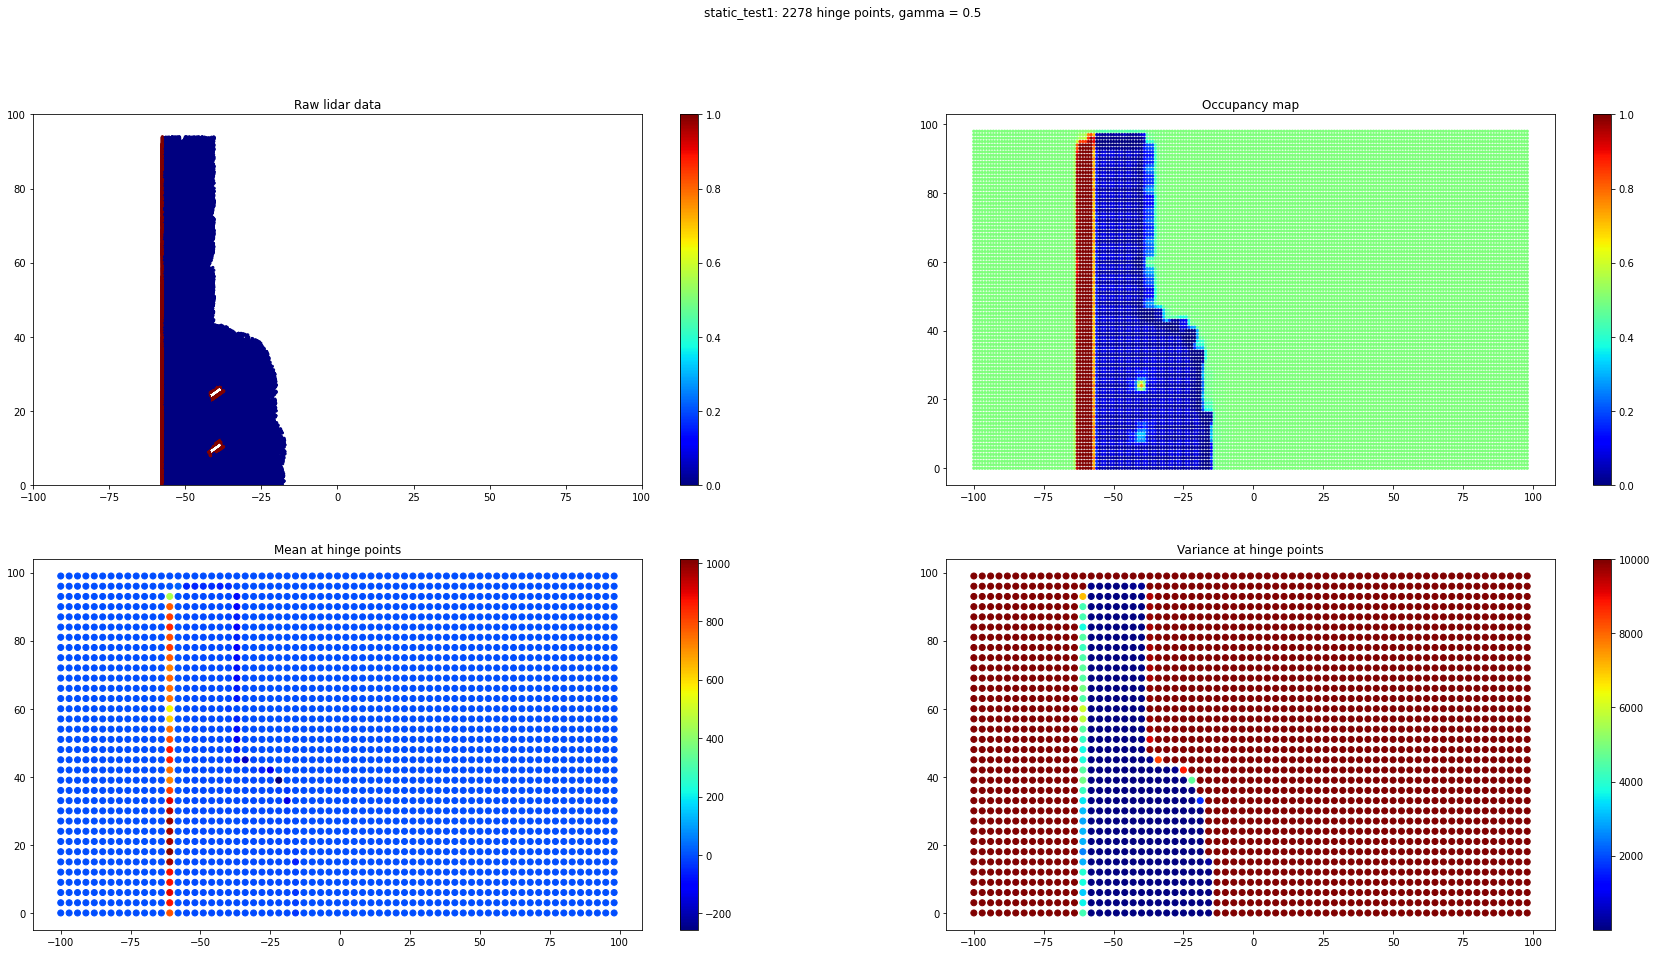

In [6]:
# Get the filename to read data points from
filename = input("Input file: ")
result = trainModel(filename)

#OT Fusion: 2 Sources

     |████████████████████████████████| 430kB 2.8MB/s 
Input file 1: static_test1
Input file 2: static_test2

Reading Datasets/simulated/static_test1.csv...


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:55: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.


 Mapping segment 1 of 1...
 Number of hinge points=2278
  Parameter estimation: iter=0
 Total training time=15.29 s


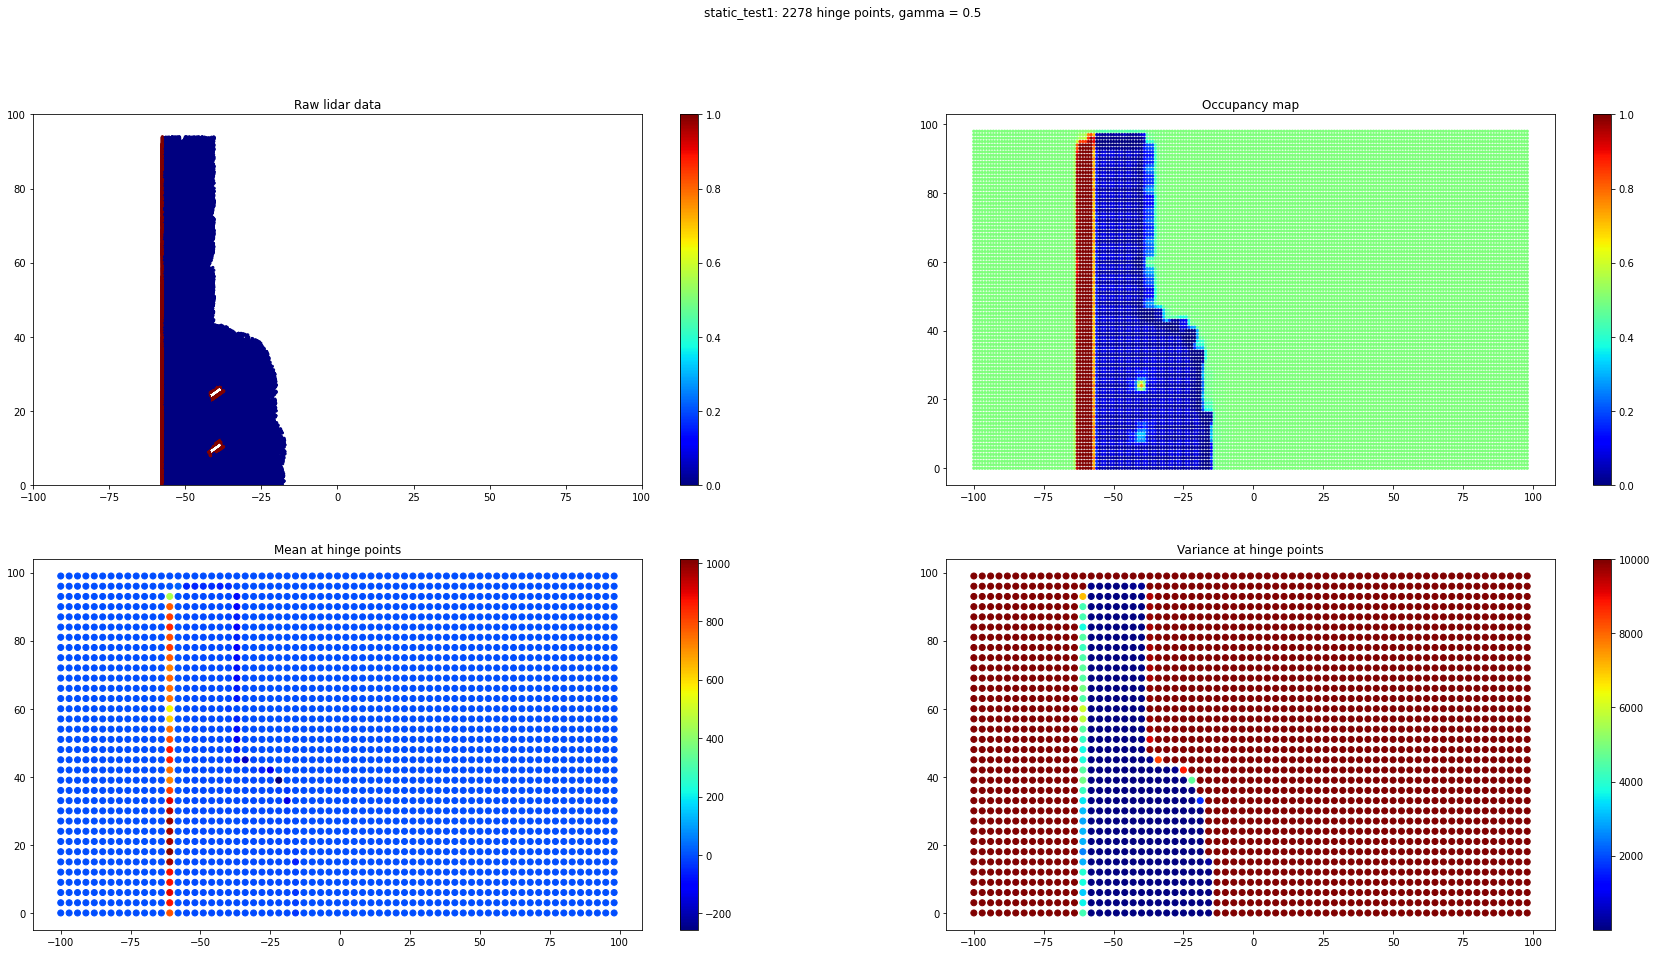


Reading Datasets/simulated/static_test2.csv...


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:55: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.


 Mapping segment 1 of 1...
 Number of hinge points=2278
  Parameter estimation: iter=0
 Total training time=8.02 s


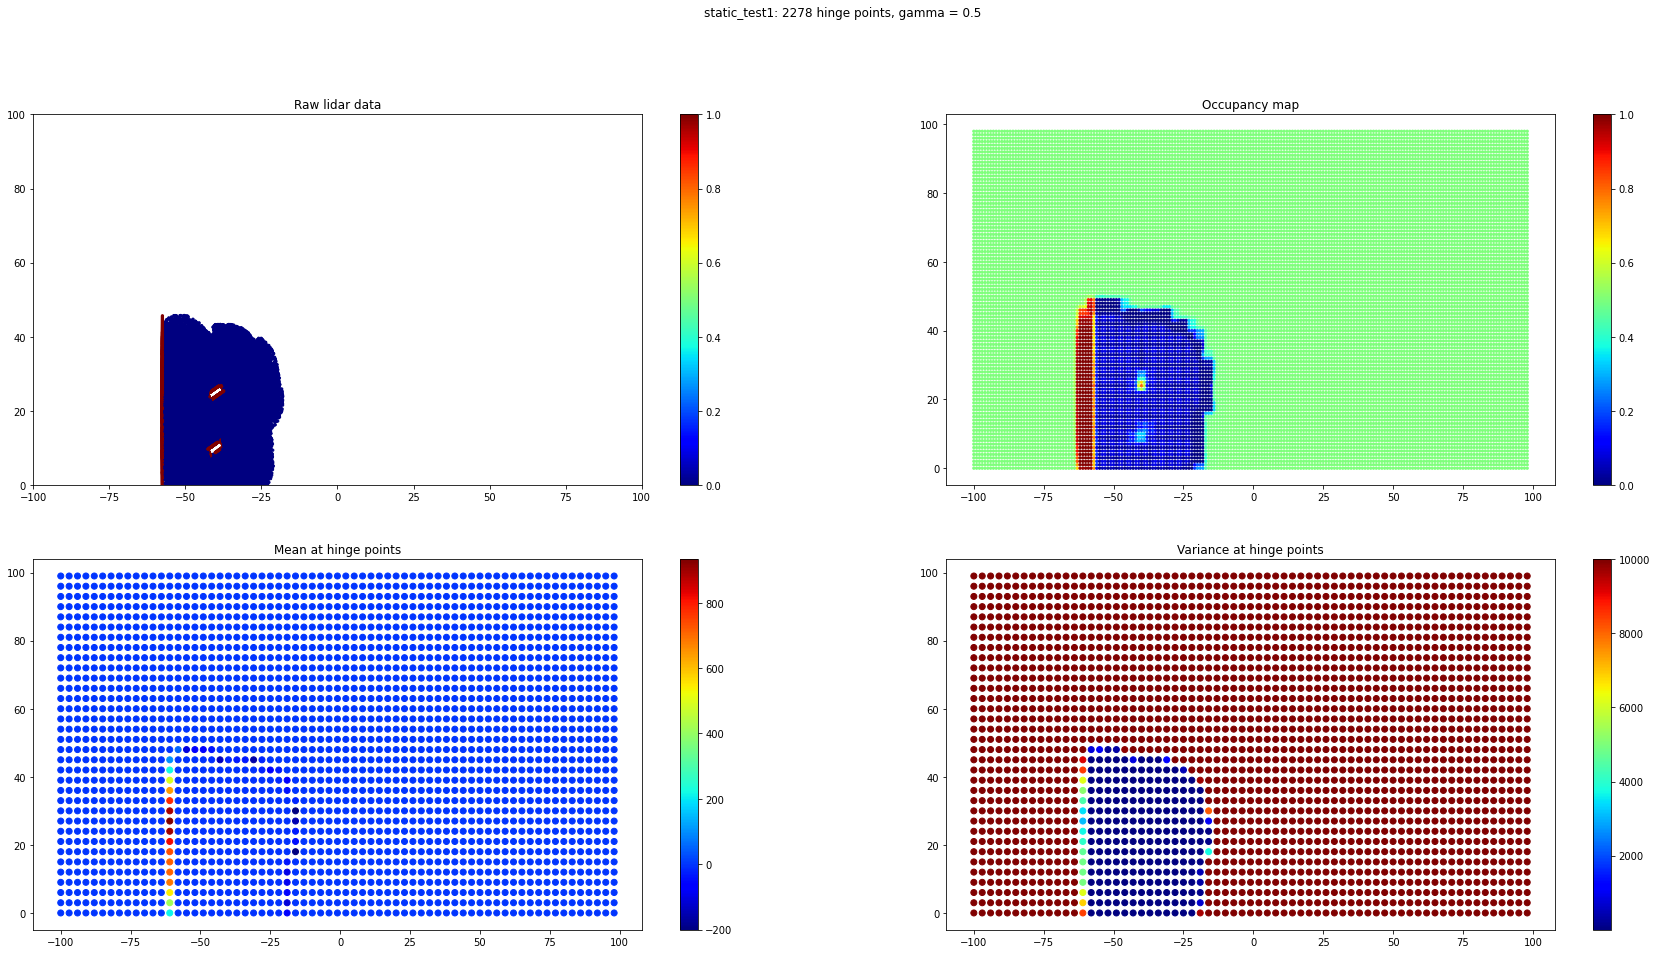

In [8]:
!pip install pot
import ot
import scipy

# Get the filenames of the 2 sources to read data points from
f1 = input("Input file 1: ")
f2 = input("Input file 2: ")

# Train the 2 models separately
weights1 = trainModel(f1)
weights2 = trainModel(f2)

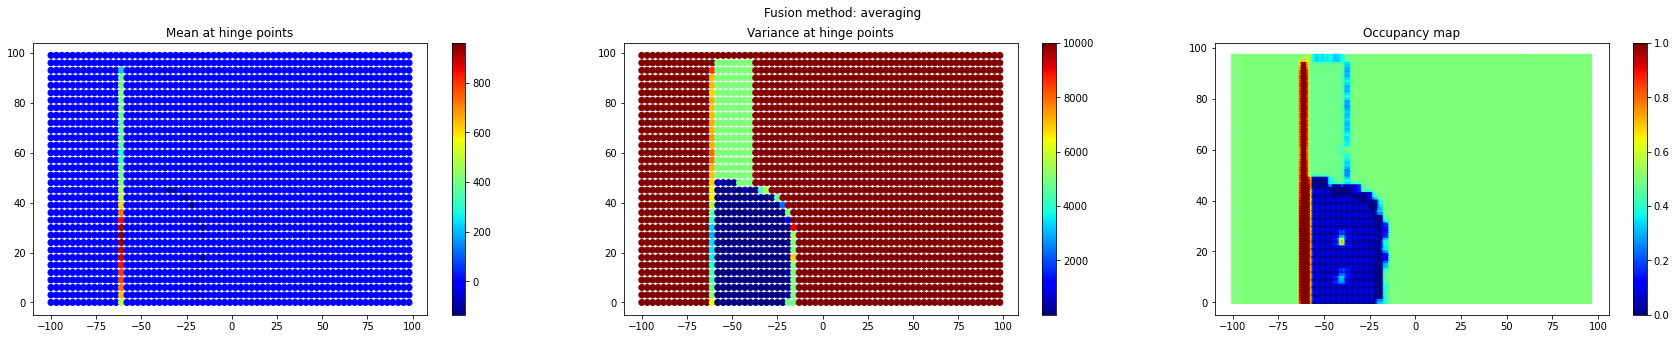

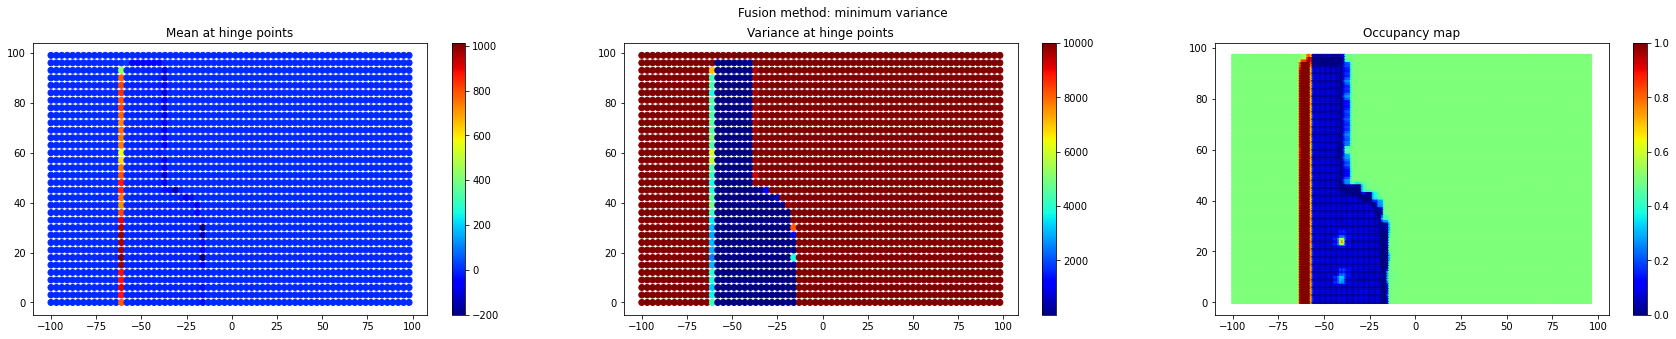

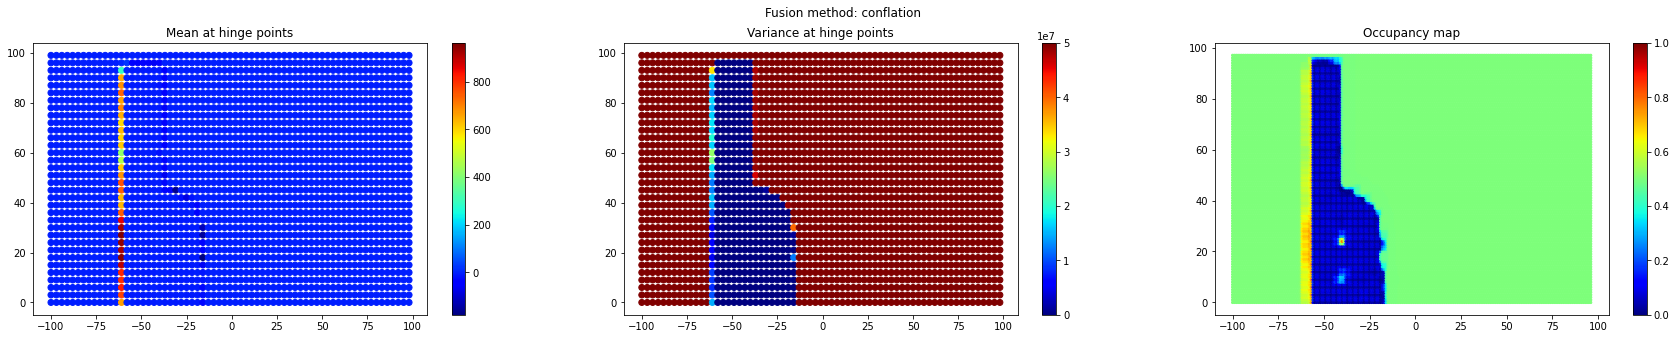

In [9]:
nWeights = []
nWeights.append(weights1)
nWeights.append(weights2)

def fusionAverages(nWeights=None):

    # Initialise arrays to store averaged data
    aveMean = []
    aveVar = []    
    
    # Loop through each hinge point
    for i in range(nWeights[0].shape[0]):

        # Get the average mean and variance 
        sumMean = 0
        sumVar = 0
        for j in range(len(nWeights)):
            sumMean += nWeights[j][i][2]
            sumVar += nWeights[j][i][3]

        aveMean.append(sumMean/len(nWeights))
        aveVar.append(sumVar/len(nWeights))
        
    # Add average mean and variance columns to matrix
    fused = np.column_stack((nWeights[0][:,0], nWeights[0][:,1], aveMean, aveVar))

    toPlot = queryFused(fused)
    return toPlot, fused

def fusionMinVar(nWeights=None):

    # Initialise arrays to store data
    mean = []
    var = []    
    
    # Loop through each hinge point
    for i in range(nWeights[0].shape[0]):

        # Find the distribution with minimum variance
        minVar = nWeights[0][i][3]
        distribution = 0
        for j in range(len(nWeights)):
            currentVar = nWeights[j][i][3]
            if currentVar < minVar:
              minVar = currentVar
              distribution = j

        # Use the data from the distribution with minimum variance
        mean.append(nWeights[distribution][i][2])
        var.append(nWeights[distribution][i][3])
        
    # Add average mean and variance columns to matrix
    fused = np.column_stack((nWeights[0][:,0], nWeights[0][:,1], mean, var))

    toPlot = queryFused(fused)
    return toPlot, fused

def fusionConflation(nWeights=None):

    # Initialise arrays to store data
    mean = []
    var = []    
    
    # Loop through each hinge point
    for i in range(nWeights[0].shape[0]):

        # Compute the new mean and variance
        mean_numerator = 0
        mean_denominator = 0
        var_denominator = 0
        for j in range(len(nWeights)):
            currentMean = nWeights[j][i][2]
            currentVar = nWeights[j][i][3]
            mean_numerator += currentMean/(currentVar**2)
            mean_denominator += 1/(currentVar**2)
            var_denominator += 1/(currentVar**2)
        
        # Store the new mean and variance values
        mean.append(mean_numerator/mean_denominator)
        var.append(1/var_denominator)
        
    # Add mean and variance columns to matrix
    fused = np.column_stack((nWeights[0][:,0], nWeights[0][:,1], mean, var))

    toPlot = queryFused(fused)
    return toPlot, fused

def queryFused(fused=None):

    # Get max/min bounds of the area
    min_x = np.amin(fused[:,0])
    max_x = np.amax(fused[:,0])
    min_y = np.amin(fused[:,1])
    max_y = np.amax(fused[:,1])

    # Query the model
    q_resolution = 1
    xx, yy= np.meshgrid(np.arange(min_x, max_x - 1, q_resolution),
                        np.arange(min_y, max_y - 1, q_resolution))
    grid = np.hstack((xx.ravel()[:, np.newaxis], yy.ravel()[:, np.newaxis]))
    Xq = pt.tensor(grid, dtype=pt.float32)
    
    # Get sparse features 
    grid = np.column_stack((fused[:,0], fused[:,1]))
    rbf_features = rbf_kernel(Xq, grid, gamma=0.5)
    sparse_Xq = pt.tensor(rbf_features, dtype=pt.float32)

    # Get mean occupancy
    mu = pt.tensor(fused[:,2], dtype=pt.float32)
    sig = pt.tensor(fused[:,3], dtype=pt.float32)
    mu_a = sparse_Xq.mm(mu.reshape(-1, 1)).squeeze()
    sig2_inv_a = pt.sum((sparse_Xq ** 2) * sig, dim=1)
    k = 1.0 / pt.sqrt(1 + np.pi * sig2_inv_a / 8)
    yq = pt.sigmoid(k*mu_a)

    toPlot = np.column_stack((Xq, yq))
    return toPlot

def plotFused(toPlot=None, fused=None, fusionType=None):

    # Scatter plot mean of weights at hinge points
    pl.figure(figsize=(30,5))
    pl.suptitle('Fusion method: '+fusionType)

    pl.subplot(131)
    pl.title('Mean at hinge points')
    pl.scatter(fused[:,0], fused[:,1], c=fused[:,2], cmap='jet')
    pl.colorbar()
    pl.gca().set_aspect('auto', adjustable='box')

    # Scatter plot variance of weights at hinge points
    pl.subplot(132)
    pl.title('Variance at hinge points')
    pl.scatter(fused[:,0], fused[:,1], c=fused[:,3], cmap='jet')
    pl.colorbar()
    pl.gca().set_aspect('auto', adjustable='box') 

    # Scatter plot occupancy map
    pl.subplot(133)
    pl.title('Occupancy map')
    pl.scatter(toPlot[:, 0], toPlot[:, 1], c=toPlot[:, 2], cmap='jet', s=5, vmin=0, vmax=1)
    pl.colorbar()
    pl.gca().set_aspect('auto', adjustable='box')

# Fuse models using averages
plotAve, fusedAverages = fusionAverages(nWeights)
plotFused(plotAve, fusedAverages, "averaging")

# Fuse models using minimum variance
plotMinVar, fusedMinVar = fusionMinVar(nWeights)
plotFused(plotMinVar, fusedMinVar, "minimum variance")

# Fuse models using conflation
plotConflated, fusedConflated = fusionConflation(nWeights)
plotFused(plotConflated, fusedConflated, "conflation")

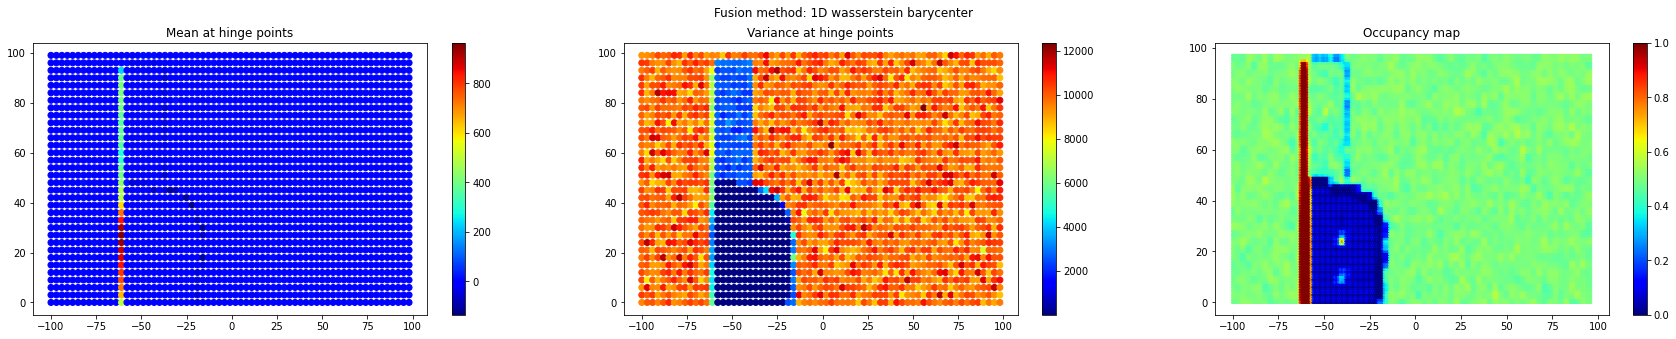

In [17]:
# Fuse models using OT
def fusionOT(nWeights=None):

    # Initialise arrays to store data
    bary_mean = []
    bary_var = []
  
    # Loop through each hinge point
    for i in range(nWeights[0].shape[0]):
        n = 200
        measures_locations = []
        measures_weights = []

        # Get each distribution
        for j in range(len(nWeights)):            
            mean = nWeights[j][i][2]
            var = nWeights[j][i][3]
            std = np.sqrt(var)
            x_i = np.random.normal(loc=mean, scale=std, size=n).reshape(-1,1)
            b_i = np.ones(n)/n
            measures_locations.append(x_i)
            measures_weights.append(b_i)

        # Compute free support barycenter
        X_init = np.random.normal(0., 1., (n, 1)) # Initial Dirac locations
        b = np.ones((n,)) / n                     # Weights of the barycenter
        X = ot.lp.free_support_barycenter(measures_locations, measures_weights, X_init, b)

        # Get the mean and variance of the barycenter
        bary_mean.append(np.mean(X))
        bary_var.append(np.var(X))

    # Add mean and variance columns to matrix
    fused = np.column_stack((nWeights[0][:,0], nWeights[0][:,1], bary_mean, bary_var))

    toPlot = queryFused(fused)
    return toPlot, fused
        
plotOT, fusedOT = fusionOT(nWeights)
plotFused(plotOT, fusedOT, "1D wasserstein barycenter")
